In [7]:
import sys
import os

# Compute absolute path to the src/ folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add src/ to sys.path
sys.path.insert(0, src_path)

# Now you can import the code
from qvarnet.hamiltonians import GeneralHamiltonian, HarmonicOscillator
from qvarnet.models.mlp import MLP
from qvarnet.samplersv2 import MetropolisHastingsSampler


import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
class SimpleModel(nn.Module):
    def __init__(self, layer_dims=[1,80,80,80, 100,1]):
        super(SimpleModel, self).__init__()
        self.mlp = MLP(layer_dims=layer_dims)

    def forward(self, x):
        psi = self.mlp(x)
        psi = psi/ psi.norm(dim=-1, keepdim=True)  # Normalize the wavefunction
        return psi

In [23]:
# model = MLP(layer_dims=[1,80,80,80, 100,1])
model = SimpleModel(layer_dims=[1, 80, 80, 80, 100, 1])
model.to(device)
print(model)

SimpleModel(
  (mlp): MLP(input_dim=1, output_dim=1, hidden_dims=[80, 80, 80, 100], activation=tanh)
)


In [24]:
import copy

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < (self.best_energy - self.min_delta):
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

- `n_samples`: Number of points generated


Number of samples: 4998
Sample mean: -0.1146
Sample std: 0.9958


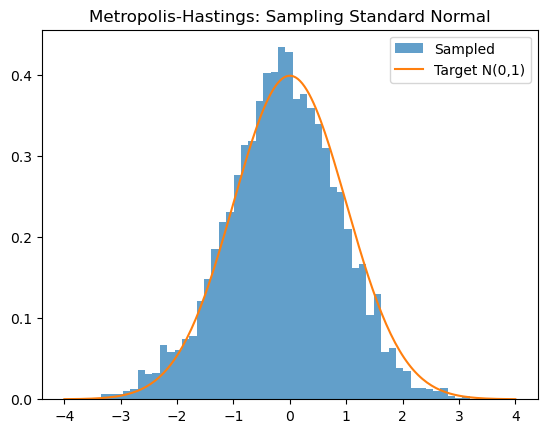

In [25]:
# Simple harmonic oscillator: E(x) = 0.5 * x^2
class HarmonicHamiltonian(GeneralHamiltonian):
    def forward(self, x):
        return 0.5 * x.pow(2).sum(dim=-1)

# Your sampler
sampler = MetropolisHastingsSampler(
    model=HarmonicHamiltonian(),
    n_samples=5000,
    step_size=0.5,
    burn_in=500,
    is_wf=False,
)

sampler.to(device)

# Initial point
x0 = torch.tensor([0.0], device=device)

# Run sampler
samples = sampler(x0, method="parallel", n_walkers=51)
samples_np = samples.cpu().detach().numpy().flatten()
print(f"Number of samples: {len(samples_np)}")

# Statistics
mean = samples_np.mean()
std = samples_np.std()

print(f"Sample mean: {mean:.4f}")
print(f"Sample std: {std:.4f}")

# Histogram
plt.hist(samples_np, bins=50, density=True, alpha=0.7, label='Sampled')
xs = torch.linspace(-4, 4, 200)
plt.plot(xs, torch.exp(-0.5 * xs**2) / (2 * torch.pi)**0.5, label='Target N(0,1)')
plt.legend()
plt.title("Metropolis-Hastings: Sampling Standard Normal")
plt.show()

In [38]:
from tqdm import tqdm
epochs = 10000

# model = MLP(layer_dims=[1, 60, 1])
# model.to(device)

hamiltonian = HarmonicOscillator(model=model)

hamiltonian.to(device)

wf_history = []
samples_history = []

n_samples = 5000

sampler = MetropolisHastingsSampler(
    model=model,
    n_samples=n_samples,
    step_size=0.5,
    burn_in=100,
    is_wf=True,
)
sampler.to(device)

callback = EarlyStoppingCallback(patience=1000, min_delta=1e-5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("model parameters:")
for name, param in model.named_parameters():
    print(name, param.shape)

# x_train = torch.linspace(-1, 1, 1000).view(-1, 1).to(device)
# x_train.requires_grad = True

# samples = torch.randn(10000, 1).to(device)
# samples.requires_grad = True

trapezoid = True

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    x0 = torch.randn(1, device=device)
    samples = sampler(x0, method="parallel", n_walkers=n_samples)
    samples.requires_grad = True
    
    # Compute the mean and std of the local energy
    local_energy = hamiltonian(samples)
    psi = model(samples)
    psi = psi/ torch.norm(psi, dim=-1, keepdim=True)
    energy = local_energy.mean().item()
    energy_std = local_energy.std().item()
    loss = local_energy.mean()

    callback(epoch, energy, model)
    if callback.stop_training:
        print("Early stopping triggered.")
        break
    
    if True and epoch % 100 == 0:
        wf_history.append(model.state_dict())
        samples_history.append(samples)
        

    # mask = torch.abs(samples.squeeze()) > 3  # shape: (batch_size,)
    
    # loss += 1e2 * (psi[mask]**2).sum()

    # boundary conditions
    # loss += 1e-2 * (psi[0]**2+ psi[-1]**2).sum()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Energy: {energy:.4f} ± {energy_std:.4f}, Loss: {loss.item():.4f}")
        
        print(sampler.get_acceptance_rate())
    
    sampler.reset_statistics()
    
    loss.squeeze().backward()
    optimizer.step()
    
print(energy)
final_model = model
final_model.load_state_dict(callback.best_model_state)

model parameters:
model.0.weight torch.Size([60, 1])
model.0.bias torch.Size([60])
model.2.weight torch.Size([1, 60])
model.2.bias torch.Size([1])
Epoch 0, Energy: 1.0549 ± 4.3256, Loss: 1.0549
0.8518732673267326
Epoch 100, Energy: 8.6638 ± 14.8706, Loss: 8.6638
0.9476574257425743
Epoch 200, Energy: 11.7558 ± 16.7548, Loss: 11.7558
0.9411544554455445
Epoch 300, Energy: 4.3926 ± 9.5225, Loss: 4.3926
0.9131742574257425
Epoch 400, Energy: 9.4161 ± 15.9922, Loss: 9.4161
0.9441683168316831
Epoch 500, Energy: 12.8569 ± 17.4332, Loss: 12.8569
0.9270118811881188
Epoch 600, Energy: 16.4374 ± 19.5297, Loss: 16.4374
0.9294871287128713
Epoch 700, Energy: 19.0281 ± 22.0031, Loss: 19.0281
0.9229920792079208
Epoch 800, Energy: 26.0541 ± 24.8608, Loss: 26.0541
0.9127069306930693
Epoch 900, Energy: 10.5095 ± 16.2066, Loss: 10.5095
0.9417049504950495
Epoch 1000, Energy: 12.4338 ± 17.6749, Loss: 12.4338
0.933629702970297
Stopping training after 1003 epochs due to no improvement in energy.
Early stopping 

<All keys matched successfully>

final model norm: 1.0


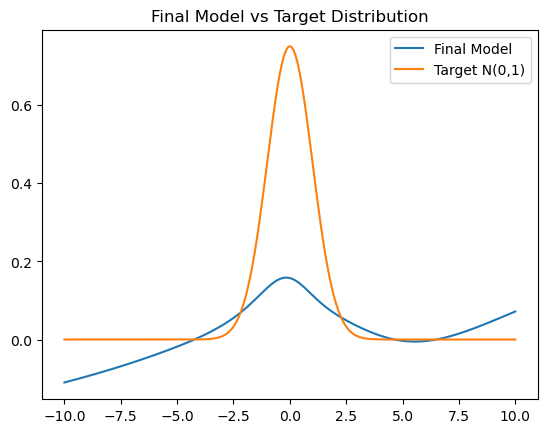

In [40]:
final_model.load_state_dict(callback.best_model_state)
x = torch.linspace(-10, 10, 200).view(-1, 1).to(device)
psi = final_model(x)
psi = psi / torch.norm(psi)

print(f"final model norm: {torch.norm(psi).item()}")

plt.plot(x.cpu().numpy(), psi.cpu().detach().numpy(), label='Final Model')
plt.plot(x.cpu().numpy(), (1/torch.pi)**(1/4)*torch.exp(-0.5 * x**2).cpu().numpy(), label='Target N(0,1)')
plt.title("Final Model vs Target Distribution")
plt.legend()
plt.show()